# Курсовой проект по теме: Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

### Требования к курсовому:

Нужно будет оформить ноутбук с основными этапами:

    подготовка данных
        анализ
        визуализация
        обработка выбросов
        обработка пропусков
        генерация фичей
    обучение модели
    проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)

За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline

Что обязательно стоит попробовать:

    Тщательный анализ данных
    Поиск странных значений
    Предобработка данных
    Генерация разнообразных признаков
    Разные модели и их разные гиперпараметры

Что не стоит пробовать:

    Кластеризация
    Модели понижения размерности


# Курсовой проект

## Описание датасета

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры



## Подготовка данных

Подключение библиотек и скриптов

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

Пути к директориям и файлам

In [3]:
DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

Оптимизация объема памяти, занимаемого датасетом

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Создание первичного понимания того, что из себя представляют данные

In [5]:
train_df = pd.read_csv(DATASET_PATH, sep=',')
train_df = reduce_mem_usage(train_df)
train_df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [6]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df = reduce_mem_usage(test_df)
test_df.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [8]:
test_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int16
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
dtype: object

Количество строк в датасетах:

In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [10]:
train_df.shape[1] - 1 == test_df.shape[1]

True

## EDA и очистка данных

Целевая переменная

Text(0.5, 1.0, 'House_price')

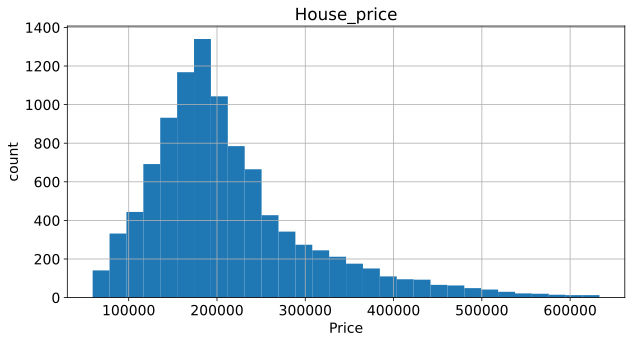

In [11]:
plt.figure(figsize = (10, 5))

train_df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('House_price')

Количественные переменные

In [12]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Номинативные переменные

In [14]:
train_df.select_dtypes(include=['category','object']).columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Обрабатываем номинативные переменные как бинарные (дамми) переменные (кроме DistrictId)

In [19]:
train_df = pd.concat([train_df, pd.get_dummies(train_df.Ecology_2, prefix='Ecology_2_')], axis=1, sort=False)  
train_df = train_df.drop(['Ecology_2'], axis=1)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2__A,Ecology_2__B
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.875000,0,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.546875,0,1
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.718750,0,1


In [20]:
train_df = pd.concat([train_df, pd.get_dummies(train_df.Ecology_3, prefix='Ecology_3_')], axis=1, sort=False)  
train_df = train_df.drop(['Ecology_3'], axis=1)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2__A,Ecology_2__B,Ecology_3__A,Ecology_3__B
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,0,NaN,0,0,B,305018.875000,0,1,0,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.546875,0,1,0,1
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.718750,0,1,0,1


In [21]:
train_df = pd.concat([train_df, pd.get_dummies(train_df.Shops_2, prefix='Shops_2_')], axis=1, sort=False)  
train_df = train_df.drop(['Shops_2'], axis=1)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2__A,Ecology_2__B,Ecology_3__A,Ecology_3__B,Shops_2__A,Shops_2__B
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,NaN,0,0,305018.875000,0,1,0,1,0,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,177734.546875,0,1,0,1,0,1
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,240.0,3,1,282078.718750,0,1,0,1,0,1


### Обработка пропусков

In [22]:
train_df.isna()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2__A,Ecology_2__B,Ecology_3__A,Ecology_3__B,Shops_2__A,Shops_2__B
0,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Price               0
Ecology_2__A        0
Ecology_2__B        0
Ecology_3__A        0
Ecology_3__B        0
Shops_2__A          0
Shops_2__B          0
dtype: int64

In [24]:
median = train_df['LifeSquare'].median()
train_df['LifeSquare'].fillna(median, inplace=True)

In [25]:
train_df['LifeSquare'].isna().sum()

0

In [26]:
median = train_df['Healthcare_1'].median()
train_df['Healthcare_1'].fillna(median, inplace=True)

In [27]:
train_df['Healthcare_1'].isna().sum()

0

In [28]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Price            0
Ecology_2__A     0
Ecology_2__B     0
Ecology_3__A     0
Ecology_3__B     0
Shops_2__A       0
Shops_2__B       0
dtype: int64

## Анализируем ошибки ввода и выбросы

### Rooms

уберем 0 значения и переведем кол-во комнат больше 6 к 5

In [29]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [30]:
train_df.loc[train_df['Rooms'] ==0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >=6, 'Rooms'] = 5

In [31]:
train_df['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2235
4.0     150
5.0      22
Name: Rooms, dtype: int64

Обрабатываем комнаты как категориальную переменную

In [32]:
train_df = pd.concat([train_df, pd.get_dummies(train_df.Rooms, prefix='Rooms_')], axis=1, sort=False)  
train_df = train_df.drop(['Rooms'], axis=1)
train_df.head(5)

,Id,DistrictId,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_2__B,Ecology_3__A,Ecology_3__B,Shops_2__A,Shops_2__B,Rooms__1.0,Rooms__2.0,Rooms__3.0,Rooms__4.0,Rooms__5.0
0,11809,27,115.027313,32.781261,10.0,4,10.0,2014,0.075424,11,...,1,0,1,0,1,0,0,1,0,0
1,3013,22,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,...,1,0,1,0,1,1,0,0,0,0
2,8215,1,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,...,1,0,1,0,1,0,0,1,0,0
3,2352,1,40.409908,32.781261,1.0,10,22.0,1977,0.007122,1,...,1,0,1,0,1,1,0,0,0,0
4,13866,94,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,...,1,0,1,0,1,0,1,0,0,0


In [33]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [34]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

## Базовая модель

In [35]:
target_name = 'Price'

In [36]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [38]:
model_RFR = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=42)

In [39]:
model_RFR.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42)

In [40]:
first_predict = model_RFR.predict(X_test)

In [41]:
r2(y_test, first_predict)

0.7320538900279346

## Проводим аналогичную очистку и обработку данных для тестового датасета

In [42]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [43]:
test_df.select_dtypes(include=['category','object']).columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [44]:
test_df['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [45]:
test_df['Ecology_3'].value_counts()

B    4851
A     149
Name: Ecology_3, dtype: int64

In [46]:
test_df['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

Обрабатываем номинативные переменные как бинарные (дамми) переменные (кроме DistrictId)

In [47]:
test_df = pd.concat([test_df, pd.get_dummies(test_df.Ecology_2, prefix='Ecology_2_')], axis=1, sort=False)  
test_df = test_df.drop(['Ecology_2'], axis=1)
test_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2__A,Ecology_2__B
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,24,4378,0,1036.0,1,1,B,0,1
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,2,629,1,NaN,0,0,A,0,1
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,9,1892,0,NaN,0,1,B,0,1


In [48]:
test_df = pd.concat([test_df, pd.get_dummies(test_df.Ecology_3, prefix='Ecology_3_')], axis=1, sort=False)  
test_df = test_df.drop(['Ecology_3'], axis=1)
test_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2__A,Ecology_2__B,Ecology_3__A,Ecology_3__B
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,...,4378,0,1036.0,1,1,B,0,1,0,1
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,...,629,1,NaN,0,0,A,0,1,0,1
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,...,1892,0,NaN,0,1,B,0,1,0,1


In [49]:
test_df = pd.concat([test_df, pd.get_dummies(test_df.Shops_2, prefix='Shops_2_')], axis=1, sort=False)  
test_df = test_df.drop(['Shops_2'], axis=1)
test_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2__A,Ecology_2__B,Ecology_3__A,Ecology_3__B,Shops_2__A,Shops_2__B
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,...,0,1036.0,1,1,0,1,0,1,0,1
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,...,1,NaN,0,0,0,1,0,1,1,0
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,...,0,NaN,0,1,0,1,0,1,0,1


Обработка пропусков

In [50]:
test_df.isna()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2__A,Ecology_2__B,Ecology_3__A,Ecology_3__B,Shops_2__A,Shops_2__B
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [51]:
test_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Ecology_2__A        0
Ecology_2__B        0
Ecology_3__A        0
Ecology_3__B        0
Shops_2__A          0
Shops_2__B          0
dtype: int64

In [52]:
median = test_df['LifeSquare'].median()
test_df['LifeSquare'].fillna(median, inplace=True)

In [53]:
test_df['LifeSquare'].isna().sum()

0

In [54]:
median = test_df['Healthcare_1'].median()
test_df['Healthcare_1'].fillna(median, inplace=True)

In [55]:
test_df['Healthcare_1'].isna().sum()

0

In [56]:
test_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Ecology_2__A     0
Ecology_2__B     0
Ecology_3__A     0
Ecology_3__B     0
Shops_2__A       0
Shops_2__B       0
dtype: int64

уберем 0 значения и переведем кол-во комнат больше 6 к 5

In [57]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [58]:
test_df.loc[test_df['Rooms'] ==0, 'Rooms'] = 1
test_df.loc[test_df['Rooms'] >=6, 'Rooms'] = 5

In [59]:
test_df['Rooms'].value_counts()

2.0    2030
1.0    1771
3.0    1099
4.0      90
5.0      10
Name: Rooms, dtype: int64

Обрабатываем комнаты как категориальную переменную

In [60]:
test_df = pd.concat([test_df, pd.get_dummies(test_df.Rooms, prefix='Rooms_')], axis=1, sort=False)  
test_df = test_df.drop(['Rooms'], axis=1)
test_df.head(5)

,Id,DistrictId,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_2__B,Ecology_3__A,Ecology_3__B,Shops_2__A,Shops_2__B,Rooms__1.0,Rooms__2.0,Rooms__3.0,Rooms__4.0,Rooms__5.0
0,4567,44,36.847630,19.094183,5.0,5,9.0,1970,0.036122,24,...,1,0,1,0,1,1,0,0,0,0
1,5925,62,42.493908,42.568134,10.0,7,17.0,2017,0.072158,2,...,1,0,1,1,0,1,0,0,0,0
2,960,27,59.463676,32.925087,9.0,19,19.0,1977,0.211401,9,...,1,0,1,0,1,0,1,0,0,0
3,3848,23,49.646030,33.893826,6.0,2,2.0,1965,0.014073,2,...,1,0,1,0,1,0,0,1,0,0
4,746,74,53.837055,32.925087,1.0,8,17.0,1977,0.309479,35,...,1,0,1,0,1,1,0,0,0,0


In [61]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [62]:
predictions = model_RFR.predict(test_df)
predictions

array([161670.20612026, 121910.08568538, 142686.20573111, ...,
       153223.09338442, 185252.84392796, 275001.15129816])

In [63]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161670.206120
1,5925,121910.085685
2,960,142686.205731
3,3848,127513.994315
4,746,200862.199823


In [64]:
print('Строк в ответе:', submit.shape[0])

Строк в ответе: 5000


In [65]:
submit.to_csv('MVPopov_predictions.csv', index=False)